<a href="https://colab.research.google.com/github/mike-ferguson/benford/blob/main/benford_verifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [182]:
# import or generate a dataset:

import pandas as pd, numpy as np
import random
import math 
from collections import Counter
from scipy import stats


# read in the dataset:
data = pd.read_csv('nyc_data.csv', encoding= 'unicode_escape')

# use this to find the columns you want to use:
print(data.columns)
col_wanted = "1999-00  Actuals"

# remove NA values or values not a number.
df = data[data[col_wanted].notna()]
df = df[pd.to_numeric(df[col_wanted], errors='coerce').notnull()]
df_final = df[col_wanted]

# casts entries to floats and make final list
numbers = list(df_final)
numbers = [float(i) for i in numbers]
numbers = [x for x in numbers if x > 0.0]


Index(['Function', 'Agency', 'Fund Type', 'FP Category', 'Fund', 'Subfund',
       'Subfund Name', '2019-20 Estimates', '2018-19 Actuals',
       '2017-18 Actuals', '2016-17 Actuals', '2015-16 Actuals',
       '2014-15 Actuals', '2013-14  Actuals', '2012-13  Actuals',
       '2011-12  Actuals', '2010-11  Actuals', '2009-10  Actuals',
       '2008-09  Actuals', '2007-08  Actuals', '2006-07  Actuals',
       '2005-06  Actuals', '2004-05  Actuals', '2003-04  Actuals',
       '2002-03  Actuals', '2001-02  Actuals', '2000-01  Actuals',
       '1999-00  Actuals', '1998-99  Actuals', '1997-98  Actuals',
       '1996-97  Actuals', '1995-96  Actuals', '1994-95  Actuals'],
      dtype='object')


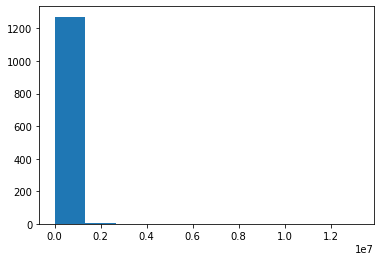

Mean:  57542.18203125
Standard Deviation:  550013.123517598


In [183]:
# look at the data to see properties, like normality:

from matplotlib import pyplot
import statistics

pyplot.hist(numbers)
pyplot.show()

mean = statistics.mean(numbers)
std = statistics.stdev(numbers)
median = statistics.median(numbers)
print("Mean: ", mean)
print("Standard Deviation: ", std)


# is mean greater then median?
if mean <= median:
  print("The mean is not greateer then the median. Your distribution might be" + 
        "off; Benford's Law might not apply...")


In [184]:
# process the raw list:
sig_list = ([x // (10**math.floor(math.log10(x))) for x in numbers])
print(sig_list[0:50])

# get Benford probabilities:
def benford (digit):
  return math.log10((digit + 1)/ digit)


[2.0, 2.0, 7.0, 5.0, 1.0, 2.0, 1.0, 1.0, 5.0, 1.0, 1.0, 4.0, 4.0, 2.0, 2.0, 7.0, 1.0, 2.0, 6.0, 1.0, 1.0, 9.0, 1.0, 2.0, 4.0, 3.0, 1.0, 8.0, 3.0, 2.0, 1.0, 4.0, 1.0, 1.0, 2.0, 4.0, 7.0, 2.0, 1.0, 8.0, 5.0, 1.0, 1.0, 1.0, 3.0, 2.0, 4.0, 8.0, 2.0, 2.0]


In [185]:
# calculate meta-statistics:

actual_freqs = Counter(sig_list)
print(actual_freqs)

limit = len(numbers)
print(limit)

predicted = []
for i in range(1, 10):
  pred_num = benford(i) * limit
  predicted.append(round(pred_num, 4))

benford_list = [1,2,3,4,5,6,7,8,9]

predicted_freqs = dict(zip(benford_list, predicted))

df = pd.DataFrame({'Predicted Values':pd.Series(predicted_freqs),'Actual Values':pd.Series(actual_freqs)})


# df["Predicted Proportion"] = df['Predicted Values'] / limit
# df["Actual Proportion"] = df['Actual Values'] / limit

df["Predicted Percent"] = (df['Predicted Values'] / limit) * 100
df["Actual Percent"] = (df['Actual Values']  / limit) * 100


print(df)

actual_props = list(df["Predicted Percent"])
predicted_props = list(df["Actual Percent"])


Counter({1.0: 374, 2.0: 246, 3.0: 158, 4.0: 124, 5.0: 118, 6.0: 82, 7.0: 80, 9.0: 54, 8.0: 44})
1280
     Predicted Values  Actual Values  Predicted Percent  Actual Percent
1.0          385.3184            374          30.103000        29.21875
2.0          225.3968            246          17.609125        19.21875
3.0          159.9216            158          12.493875        12.34375
4.0          124.0448            124           9.691000         9.68750
5.0          101.3520            118           7.918125         9.21875
6.0           85.6919             82           6.694680         6.40625
7.0           74.2297             80           5.799195         6.25000
8.0           65.4752             44           5.115250         3.43750
9.0           58.5696             54           4.575750         4.21875


In [186]:
# create test statistic:
chi_squared = 0
for i in range(0,9):
  error = ((actual_props[i] - predicted_props[i]) ** 2) / predicted_props[i]
  chi_squared  = chi_squared + error

print(chi_squared)

1.2414724067847849


In [187]:
# conduct actual hypthesis test:
# H0: All digits 1-9 Conform to the predicted Benford's Law Proportion
# H1: At least 1 digit does not conform to the predictions.


dof = 8

value = 1 - stats.chi2.cdf(chi_squared, dof)
print( "P value: " ,value)
print( "Alpha: " , 0.05)


if value < 0.05:
  print("Results are significant at this Alpha Level (0.05). \nThis indicates " + 
        "very strong evidence that Benford's Law is NOT obeyed. H0 is rejected.")
else:
  print("Results are not statistically significant. \nThis indicates " + 
        "very strong evidence that Benford's Law IS obeyed. Fail to reject H0.")

P value:  0.9962150267925126
Alpha:  0.05
Results are not statistically significant. 
This indicates very strong evidence that Benford's Law IS obeyed. Fail to reject H0.


**History of Data Tested so Far:**

-- Dataset | Column | Chi-Squre Value | p-Value | Result -- 

1) NYC Property Sales, SALE PRICE, 6.0326, 0.64357, **Obeys**

2) Video Game Sales, NA_Sales, 28.801, 0.00034, **Does not Obey**

3) Video Game Sales, EU_Sales, 66.899, 2.029E-11, **Does not Obey**

4) Video Game Sales, JP_Sales, 81.6581, 2.264E-14, **Does not Obey**

5) Sample Sales Data, SALES, 30.505, 1.721E-4, **Does not Obey**

6) Sample Sales Data, QUANTITYORDERED, 2999.20, 0.0, **Does not Obey**

7) Car sales, Sales_in_thousands, 3.219, 0.9198, **Obeys**

8) NYS New York State Budget and Actuals, 2018-19 Actuals, 4.704, 0.78866, **Obeys**

9) NYS New York State Budget and Actuals, 1994-95  Actuals, 0.4417, 0.99991, **Obeys**

10) NYS New York State Budget and Actuals, 1999-00  Actuals, 1.241, 0.9962, **Obeys**



**Links to Datasets:**

1) https://www.kaggle.com/new-york-city/nyc-property-sales

2, 3, 4) https://www.kaggle.com/gregorut/videogamesales

5, 6) https://www.kaggle.com/kyanyoga/sample-sales-data

7) https://www.kaggle.com/gagandeep16/car-sales

8, 9) https://www.kaggle.com/new-york-state/nys-new-york-state-budget-and-actuals
